# Maestría en Inteligencia Artificial Aplicada

## ****Proyecto Integrador: Sistema de visión computacional para normalización y validación visual de anaqueles fríos****

### Tecnológico de Monterrey


## Actividad de la Semana 7
### **Avance 3. Modelo final**


#### **Nombre de estudiantes:**

**Carlos Eduardo Ramírez Vázquez** Matrícula: A01795468

**Cesar Bryam Rodriguez Aybar**    Matrícula: A01795980

**Wilberth Eduardo López Gómez**   Matrícula: A01795997

In [1]:
import os, json, random, math
from pathlib import Path

import numpy as np
import cv2
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

data_path = "/content/drive/MyDrive/Maestria/Proyecto integrador/Proyecto IA: Anaqueles frios/Data/"

IMG_DIR = Path(data_path + "unfisheye_data")
ANN_PATH = Path(data_path + "annotations/all_annotations.json")

Mounted at /content/drive


# Validaciones iniciales

In [2]:
def _pick(d: dict, keys):
    for k in keys:
        if k in d and d[k] is not None:
            return d[k]
    return None

def load_annotations(ann_path: Path, img_dir: Path):
    data = json.loads(ann_path.read_text(encoding="utf-8"))

    if isinstance(data, list):
        items = data
    elif isinstance(data, dict):
        items = _pick(data, ["images", "items", "data"])
        if items is None:
            if all(isinstance(v, dict) for v in data.values()):
                items = list(data.values())
            else:
                raise ValueError("No pude inferir la lista de imágenes dentro del JSON.")
    else:
        raise ValueError("Formato JSON no soportado.")

    records = []
    for it in items:
        img_rel = _pick(it, ["image_path", "path", "file_name", "filename", "img_path"])
        if img_rel is None:
            raise ValueError(f"Item sin ruta de imagen: keys={list(it.keys())[:10]}")

        doors = _pick(it, ["doors", "annotations", "objects", "polygons"])
        if doors is None:
            raise ValueError(f"Item sin lista de puertas/annotations: keys={list(it.keys())[:10]}")

        # Normalizar doors a lista de puertas, donde cada puerta tiene 4 vertices (x,y)
        norm_doors = []
        for d in doors:
            verts = _pick(d, ["vertices", "points", "keypoints", "polygon"])
            if verts is None:
                if isinstance(d, list):
                    verts = d
                else:
                    raise ValueError(f"Puerta sin vertices/points: keys={list(d.keys())[:10]}")

            pts = []
            for p in verts:
                if isinstance(p, dict):
                    x = _pick(p, ["x", "X"])
                    y = _pick(p, ["y", "Y"])
                    if x is None or y is None:
                        raise ValueError(f"Punto dict sin x/y: {p}")
                    pts.append([float(x), float(y)])
                else:
                    # lista/tupla
                    pts.append([float(p[0]), float(p[1])])

            if len(pts) != 4:
                raise ValueError(f"Esperaba 4 puntos por puerta; obtuve {len(pts)} en {img_rel}")

            norm_doors.append(np.array(pts, dtype=np.float32))

        records.append({
            "image_path": str((img_dir / img_rel).resolve()) if not os.path.isabs(img_rel) else img_rel,
            "doors": norm_doors,
        })

    return records

records = load_annotations(ANN_PATH, IMG_DIR)
print(f"Imágenes cargadas: {len(records)}")
print("Ejemplo keys:", records[0].keys())
print("Ejemplo #puertas:", len(records[0]["doors"]))

Imágenes cargadas: 26
Ejemplo keys: dict_keys(['image_path', 'doors'])
Ejemplo #puertas: 4


In [3]:
def read_image_shape(path):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"No pude leer imagen: {path}")
    h, w = img.shape[:2]
    return w, h

n_doors_list = []
bad = 0
for r in records:
    w, h = read_image_shape(r["image_path"])
    n_doors_list.append(len(r["doors"]))

    for door in r["doors"]:
        xs, ys = door[:,0], door[:,1]
        if xs.min() < 0 or ys.min() < 0 or xs.max() > w or ys.max() > h:
            bad += 1

print("Distribución #puertas:", {k: n_doors_list.count(k) for k in sorted(set(n_doors_list))})
print("Puertas con puntos fuera de rango (posibles desalineaciones):", bad)

Distribución #puertas: {2: 2, 3: 8, 4: 16}
Puertas con puntos fuera de rango (posibles desalineaciones): 0


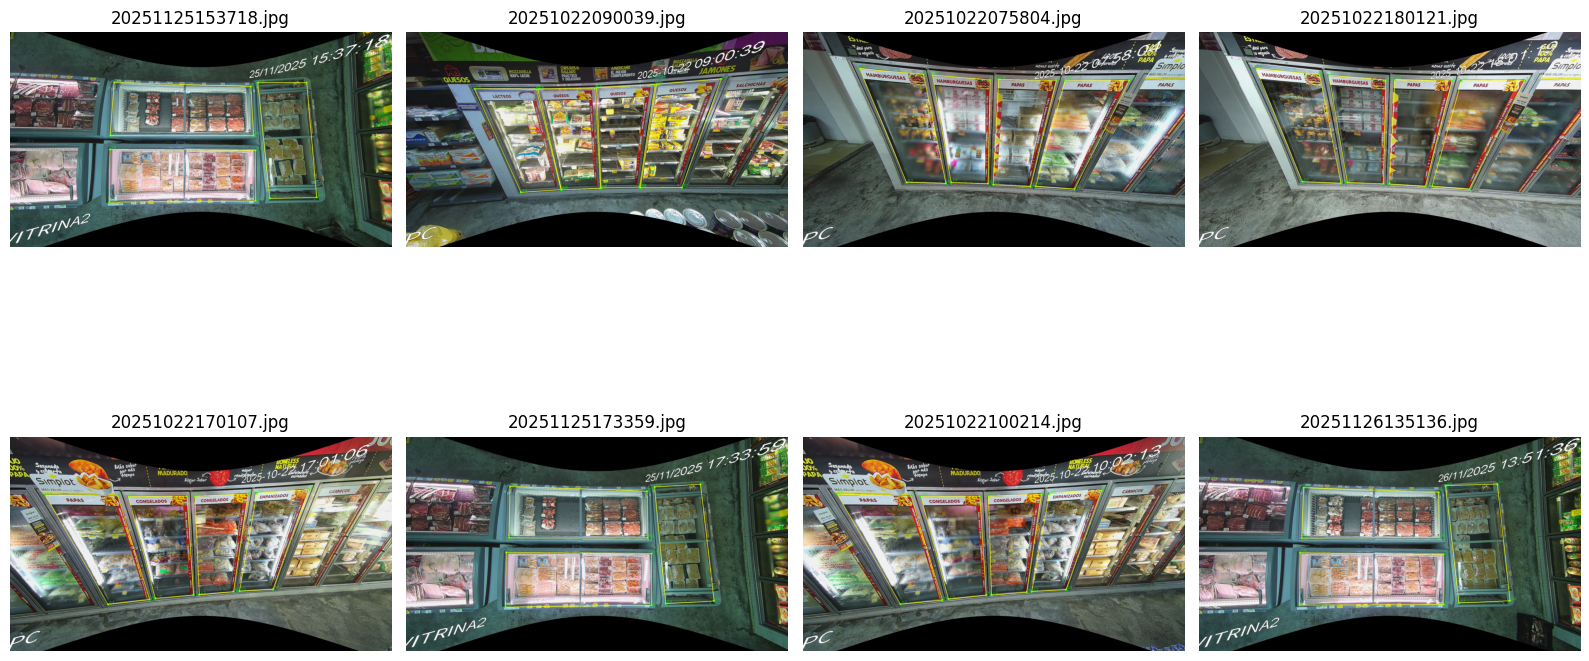

In [4]:
def draw_doors(img_bgr, doors, radius=6):
    img = img_bgr.copy()
    for di, door in enumerate(doors):
        # Puntos
        for pi, (x,y) in enumerate(door):
            cv2.circle(img, (int(x), int(y)), radius, (0,255,0), -1)
            cv2.putText(img, f"{di}:{pi}", (int(x)+6, int(y)-6),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1, cv2.LINE_AA)
        # Polígono
        poly = door.reshape(-1,1,2).astype(np.int32)
        cv2.polylines(img, [poly], isClosed=True, color=(0,255,255), thickness=2)
    return img

def show_random(n=6, seed=SEED):
    rng = random.Random(seed)
    sample = rng.sample(records, min(n, len(records)))
    plt.figure(figsize=(16, 10))
    for i, r in enumerate(sample, 1):
        img = cv2.imread(r["image_path"])
        img = draw_doors(img, r["doors"])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2, math.ceil(len(sample)/2), i)
        plt.imshow(img_rgb)
        plt.axis("off")
        plt.title(Path(r["image_path"]).name)
    plt.tight_layout()
    plt.show()

show_random(n=8)

In [5]:
def order_vertices_tl_tr_br_bl(pts):
    """
    pts: (4,2) float32
    Retorna: (4,2) en orden TL, TR, BR, BL.
    """
    pts = pts.copy()
    # TL = min(x+y), BR = max(x+y); TR = max(x-y), BL = min(x-y)
    s = pts.sum(axis=1)
    d = (pts[:,0] - pts[:,1])
    tl = pts[np.argmin(s)]
    br = pts[np.argmax(s)]
    tr = pts[np.argmax(d)]
    bl = pts[np.argmin(d)]
    return np.stack([tl, tr, br, bl], axis=0).astype(np.float32)

def sort_doors_left_to_right(doors):
    # ordenar por centroide en x
    centroids = [door[:,0].mean() for door in doors]
    idx = np.argsort(centroids)
    return [doors[i] for i in idx]

def canonicalize_record(r):
    doors = [order_vertices_tl_tr_br_bl(d) for d in r["doors"]]
    doors = sort_doors_left_to_right(doors)
    return {"image_path": r["image_path"], "doors": doors}

records_c = [canonicalize_record(r) for r in records]

# Baseline usando YOLO Pose (Ultralytics) + fine-tuning

In [6]:
!pip -q install ultralytics opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 69.4 MB/s eta 0:00:00


In [8]:
import os, json, random, math, shutil
from pathlib import Path

import numpy as np
import cv2
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

YOLO_ROOT = Path(data_path + "yolo_doors_pose_2002b1")  # Actualizar esto en cada ejecución completa de este notebook

In [9]:
def order_vertices_tl_tr_br_bl(pts):
    pts = np.array(pts, dtype=np.float32).copy()
    s = pts.sum(axis=1)
    d = (pts[:,0] - pts[:,1])
    tl = pts[np.argmin(s)]
    br = pts[np.argmax(s)]
    tr = pts[np.argmax(d)]
    bl = pts[np.argmin(d)]
    return np.stack([tl, tr, br, bl], axis=0).astype(np.float32)

def sort_doors_left_to_right(doors):
    centroids_x = [np.mean(np.array(d)[:,0]) for d in doors]
    idx = np.argsort(centroids_x)
    return [doors[i] for i in idx]

def load_records_simple(ann_path: Path, img_dir: Path):
    data = json.loads(ann_path.read_text(encoding="utf-8"))
    if isinstance(data, dict) and "images" in data:
        items = data["images"]
    elif isinstance(data, list):
        items = data
    elif isinstance(data, dict):
        items = list(data.values())
    else:
        raise ValueError("JSON no soportado.")

    recs = []
    for it in items:
        img_rel = it.get("image_path") or it.get("path") or it.get("file_name") or it.get("filename")
        doors = it.get("doors") or it.get("annotations") or it.get("objects") or it.get("polygons")
        if img_rel is None or doors is None:
            continue

        full_path = Path(img_rel)
        if not full_path.is_absolute():
            full_path = (img_dir / img_rel).resolve()

        norm_doors = []
        for d in doors:
            verts = d.get("vertices") if isinstance(d, dict) else None
            if verts is None:
                verts = d.get("points") if isinstance(d, dict) else None
            if verts is None and isinstance(d, list):
                verts = d
            if verts is None:
                continue

            pts = []
            for p in verts:
                if isinstance(p, dict):
                    pts.append([float(p["x"]), float(p["y"])])
                else:
                    pts.append([float(p[0]), float(p[1])])

            if len(pts) != 4:
                continue

            pts = order_vertices_tl_tr_br_bl(pts)
            norm_doors.append(pts)

        if not norm_doors:
            continue

        norm_doors = sort_doors_left_to_right(norm_doors)
        recs.append({"image_path": str(full_path), "doors": norm_doors})

    if not recs:
        raise ValueError("No se cargaron registros. Revisa el esquema del JSON/rutas.")
    return recs

records = load_records_simple(ANN_PATH, IMG_DIR)
print("Imágenes con al menos 1 puerta:", len(records))
print("Ejemplo:", records[0]["image_path"], "#doors:", len(records[0]["doors"]))

Imágenes con al menos 1 puerta: 26
Ejemplo: /content/drive/MyDrive/Maestria/Proyecto integrador/Proyecto IA: Anaqueles frios/Data/unfisheye_data/20251022075804.jpg #doors: 4


In [10]:
def strat_key(r):
    return min(len(r["doors"]), 4)

# split 80/20
byk = {}
for r in records:
    byk.setdefault(strat_key(r), []).append(r)

train, val = [], []
for k, lst in byk.items():
    random.shuffle(lst)
    cut = max(1, int(0.8 * len(lst))) if len(lst) > 1 else 1
    train += lst[:cut]
    val   += lst[cut:]

print("Train:", len(train), "Val:", len(val), "Distribución val:", {k: sum(1 for r in val if strat_key(r)==k) for k in sorted(byk)})

Train: 19 Val: 7 Distribución val: {2: 1, 3: 2, 4: 4}


In [11]:
def make_dirs(root: Path):
    for p in [
        root/"images/train", root/"images/val",
        root/"labels/train", root/"labels/val",
    ]:
        p.mkdir(parents=True, exist_ok=True)

def bbox_from_quad(quad):
    xs, ys = quad[:,0], quad[:,1]
    x1, y1, x2, y2 = float(xs.min()), float(ys.min()), float(xs.max()), float(ys.max())
    return x1, y1, x2, y2

def yolo_norm_bbox(x1,y1,x2,y2,W,H):
    cx = ((x1+x2)/2)/W
    cy = ((y1+y2)/2)/H
    w  = (x2-x1)/W
    h  = (y2-y1)/H
    return cx, cy, w, h

def write_label_pose(txt_path: Path, doors, W, H, max_doors=4):
    # Tomamos las primeras 4 puertas desde la izquierda
    doors = doors[:max_doors]

    lines = []
    for quad in doors:
        x1,y1,x2,y2 = bbox_from_quad(quad)
        cx,cy,w,h = yolo_norm_bbox(x1,y1,x2,y2,W,H)

        kpts = []
        for (x,y) in quad:
            kpts += [x/W, y/H, 2]
        # Clase 0 = "door"
        row = [0, cx, cy, w, h] + kpts
        lines.append(" ".join(f"{v:.6f}" if isinstance(v, float) else str(v) for v in row))

    txt_path.write_text("\n".join(lines) + ("\n" if lines else ""), encoding="utf-8")

def export_split(split, split_name: str):
    for r in split:
        src = Path(r["image_path"])
        img = cv2.imread(str(src))
        if img is None:
            continue
        H, W = img.shape[:2]

        dst_img = YOLO_ROOT / f"images/{split_name}/{src.name}"
        dst_lbl = YOLO_ROOT / f"labels/{split_name}/{src.stem}.txt"

        shutil.copy2(src, dst_img)
        write_label_pose(dst_lbl, r["doors"], W, H)

make_dirs(YOLO_ROOT)
export_split(train, "train")
export_split(val, "val")

print("Ejemplo label:", (YOLO_ROOT/"labels/train").glob("*.txt").__iter__().__next__())

Ejemplo label: /content/drive/MyDrive/Maestria/Proyecto integrador/Proyecto IA: Anaqueles frios/Data/yolo_doors_pose_2002b1/labels/train/20251022170107.txt


In [12]:
from pathlib import Path

data_yaml = Path("/content/drive/MyDrive/Maestria/Proyecto integrador/Proyecto IA: Anaqueles frios/Data/yolo_doors_pose/data.yaml")
YOLO_ROOT = data_yaml.parent  # .../yolo_doors_pose

data_yaml.write_text(
f'''path: "{YOLO_ROOT}"

train: images/train
val: images/val

nc: 1
names:
  0: door

kpt_shape: [4, 3]
# TL, TR, BR, BL. Si activaras flip horizontal: TL<->TR y BL<->BR
flip_idx: [1, 0, 3, 2]
''',
encoding="utf-8"
)

print(data_yaml.read_text())

path: "/content/drive/MyDrive/Maestria/Proyecto integrador/Proyecto IA: Anaqueles frios/Data/yolo_doors_pose"

train: images/train
val: images/val

nc: 1
names:
  0: door

kpt_shape: [4, 3]
# TL, TR, BR, BL. Si activaras flip horizontal: TL<->TR y BL<->BR
flip_idx: [1, 0, 3, 2]



In [53]:
from ultralytics import YOLO

# Intentar varios nombres de pesos preentrenados (cambian según versión)
candidates = ["yolov8s-pose.pt"]
model = None
last_err = None
for w in candidates:
    try:
        model = YOLO(w)
        print("Usando pesos:", w)
        break
    except Exception as e:
        last_err = e

if model is None:
    raise RuntimeError(f"No pude cargar pesos pose. Último error: {last_err}")

train_res = model.train(
    data=str(data_yaml),
    epochs=120,
    imgsz=1280,
    batch=8,
    lr0=5e-4,
    lrf=0.1,
    weight_decay=1e-5,
    patience=30,
    pose=45.0,
    # Augmentation aun conservadora
    mosaic=0.0,
    fliplr=0.1,
    flipud=0.0,
    degrees=2.0,
    translate=0.02,
    scale=0.05,
    shear=0.0,
    perspective=0.0,
    # Freeze parcial que nos yuda con nuestro dataset diminuto
    freeze=0,
    verbose=True
)

Usando pesos: yolov8s-pose.pt
Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (NVIDIA L4, 22563MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Maestria/Proyecto integrador/Proyecto IA: Anaqueles frios/Data/yolo_doors_pose/data.yaml, degrees=2.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=120, erasing=0.4, exist_ok=False, fliplr=0.1, flipud=0.0, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1280, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.1, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-pose.pt, momentum=0.937, mosaic=0.0, multi_scale=0.0, na

In [54]:
def nme(pred_pts, gt_pts, W, H):
    diag = math.sqrt(W*W + H*H)
    return float(np.mean(np.linalg.norm(pred_pts - gt_pts, axis=1)) / diag)

def pck(pred_pts, gt_pts, thr_px=10):
    err = np.linalg.norm(pred_pts - gt_pts, axis=1)
    return float(np.mean(err < thr_px))

def load_gt_from_label(txt_path: Path, W, H):
    """
    Lee label YOLO Pose y reconstruye quads en px.
    Retorna lista de quads (4,2) en TL,TR,BR,BL.
    """
    if not txt_path.exists():
        return []
    lines = [l.strip() for l in txt_path.read_text().splitlines() if l.strip()]
    quads = []
    for l in lines:
        parts = l.split()
        if len(parts) < 5 + 12:
            continue
        k = parts[5:]
        pts = []
        for i in range(0, 12, 3):
            x = float(k[i]) * W
            y = float(k[i+1]) * H
            pts.append([x,y])
        quads.append(np.array(pts, dtype=np.float32))
    # Ya están en orden canónico porque así los exportamos
    # Limitamos a 4 de izquierda a derecha
    quads = sort_doors_left_to_right(quads)[:4]
    return quads

def predict_quads_ultralytics(model, img_path: Path, conf=0.25):
    r = model.predict(source=str(img_path), conf=conf, verbose=False)[0]
    if r.keypoints is None:
        return []
    # Keypoints.xy: (n, k, 2) en px
    kxy = r.keypoints.xy.cpu().numpy()  # (n,4,2) esperado
    # Ordenamos por centroide "x" y quedarse con los 4 más a la izquierda
    quads = [kxy[i].astype(np.float32) for i in range(kxy.shape[0])]
    quads = sort_doors_left_to_right(quads)[:4]
    return quads

def eval_yolo_pose(model, yolo_root: Path, thr_px=10):
    val_imgs = sorted((yolo_root/"images/val").glob("*"))
    nme_list, pck_list, cover_list = [], [], []

    for img_path in val_imgs:
        img = cv2.imread(str(img_path))
        if img is None:
            continue
        H, W = img.shape[:2]

        gt = load_gt_from_label(yolo_root/"labels/val"/f"{img_path.stem}.txt", W, H)
        pred = predict_quads_ultralytics(model, img_path, conf=0.25)

        m = min(len(gt), len(pred))
        if len(gt) == 0:
            continue

        cover_list.append(m / len(gt))
        if m == 0:
            continue

        pred_pts = np.stack(pred[:m], axis=0).reshape(-1,2)
        gt_pts   = np.stack(gt[:m], axis=0).reshape(-1,2)

        nme_list.append(nme(pred_pts, gt_pts, W, H))
        pck_list.append(pck(pred_pts, gt_pts, thr_px))

    return {
        "n_val_images": len(val_imgs),
        "mean_nme": float(np.mean(nme_list)) if nme_list else None,
        "mean_pck": float(np.mean(pck_list)) if pck_list else None,
        "mean_cover": float(np.mean(cover_list)) if cover_list else None,
        "n_eval": len(nme_list),
    }

summary_pose = eval_yolo_pose(model, YOLO_ROOT, thr_px=10)
summary_pose

{'n_val_images': 7,
 'mean_nme': 0.008091165285025324,
 'mean_pck': 0.20833333333333331,
 'mean_cover': 1.0,
 'n_eval': 7}

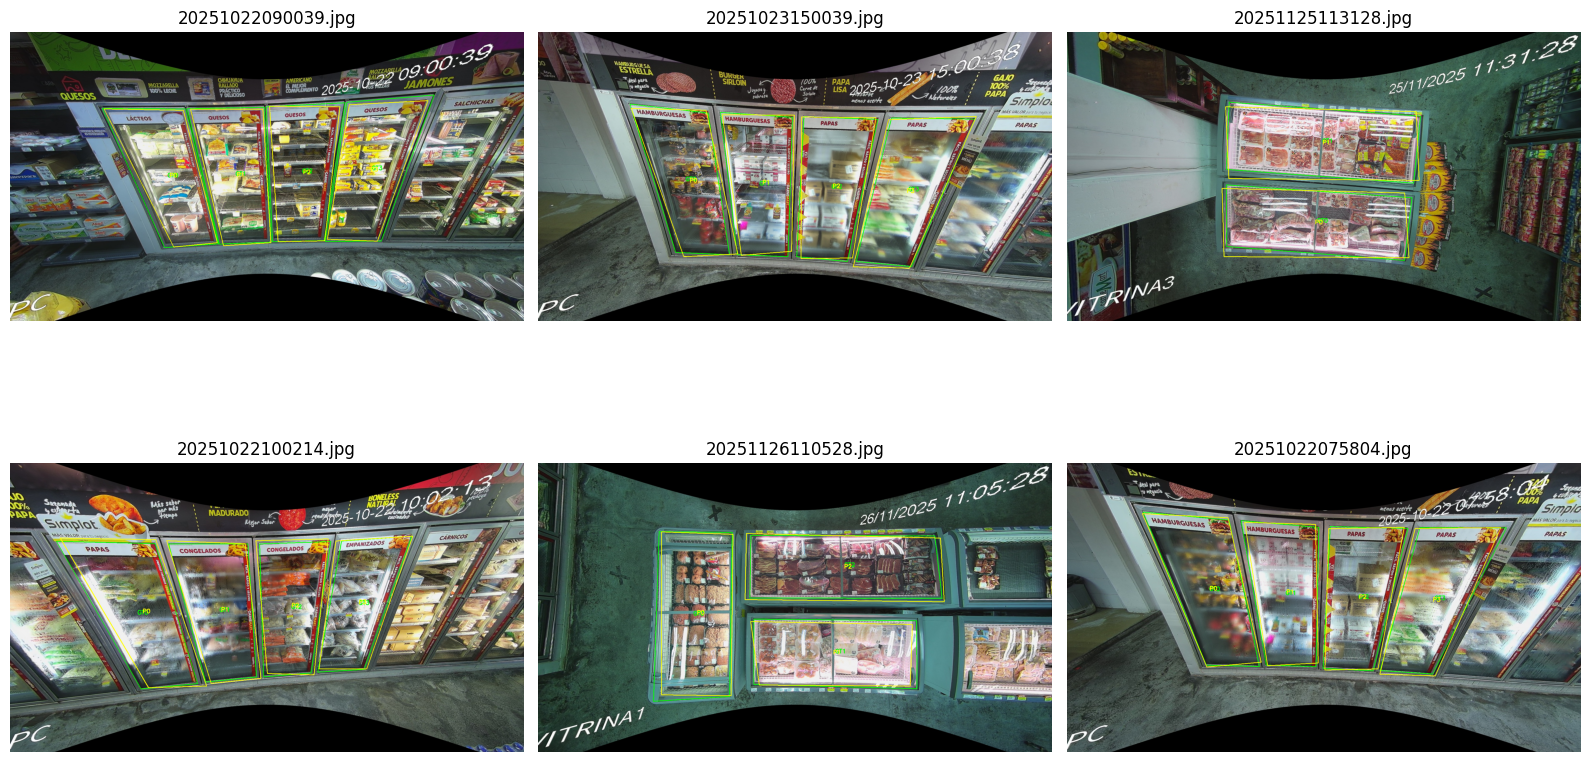

In [55]:
def draw_quads(img_bgr, quads, color, label):
    out = img_bgr.copy()
    for i, q in enumerate(quads):
        poly = q.reshape(-1,1,2).astype(np.int32)
        cv2.polylines(out, [poly], True, color, 2)
        cx = int(q[:,0].mean()); cy = int(q[:,1].mean())
        cv2.putText(out, f"{label}{i}", (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
    return out

def show_preds(n=6, seed=42):
    imgs = sorted((YOLO_ROOT/"images/val").glob("*"))
    random.Random(seed).shuffle(imgs)
    imgs = imgs[:min(n, len(imgs))]

    plt.figure(figsize=(16, 10))
    for i, p in enumerate(imgs, 1):
        img = cv2.imread(str(p))
        H, W = img.shape[:2]
        gt = load_gt_from_label(YOLO_ROOT/"labels/val"/f"{p.stem}.txt", W, H)
        pr = predict_quads_ultralytics(model, p, conf=0.25)

        vis = draw_quads(img, gt, (0,255,0), "GT")
        vis = draw_quads(vis, pr, (0,255,255), "P")

        vis = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)
        plt.subplot(2, math.ceil(len(imgs)/2), i)
        plt.imshow(vis); plt.axis("off"); plt.title(p.name)

    plt.tight_layout(); plt.show()

show_preds()

## Análisis

Cobertura (mean_cover = 1.0): en las 7 imágenes de validación, el modelo está produciendo al menos tantas puertas como las etiquetadas, a diferencia del baseline anterior.

NME = 0.0352: error medio ≈ 3.5% de la diagonal. Al ser imágenes de ~1920×1080 (diag ≈ 2203 px), el error medio ronda ~77 px por vértice.

PCK@10px = 0.0179: bajo, pero coherente con ~77 px de error medio. Con tan poca data, es esperable que el error medio sea aun alto.

In [68]:
def eval_yolo_pose_multi_pck(model, yolo_root, thrs=(10,20,50,100)):
    val_imgs = sorted((Path(yolo_root)/"images/val").glob("*"))
    pcks = {t: [] for t in thrs}
    nmes, covers = [], []

    for img_path in val_imgs:
        img = cv2.imread(str(img_path))
        if img is None:
            continue
        H, W = img.shape[:2]
        gt = load_gt_from_label(Path(yolo_root)/"labels/val"/f"{img_path.stem}.txt", W, H)
        pred = predict_quads_ultralytics(model, img_path, conf=0.25)

        m = min(len(gt), len(pred))
        if len(gt) == 0:
            continue
        covers.append(m/len(gt))
        if m == 0:
            continue

        pred_pts = np.stack(pred[:m], axis=0).reshape(-1,2)
        gt_pts   = np.stack(gt[:m], axis=0).reshape(-1,2)
        nmes.append(nme(pred_pts, gt_pts, W, H))
        for t in thrs:
            pcks[t].append(pck(pred_pts, gt_pts, t))

    return {
        "n_val_images": len(val_imgs),
        "mean_nme": float(np.mean(nmes)) if nmes else None,
        "mean_cover": float(np.mean(covers)) if covers else None,
        **{f"mean_pck@{t}px": float(np.mean(pcks[t])) if pcks[t] else None for t in thrs}
    }

eval_yolo_pose_multi_pck(model, YOLO_ROOT)

{'n_val_images': 7,
 'mean_nme': 0.008091165285025324,
 'mean_cover': 1.0,
 'mean_pck@10px': 0.20833333333333331,
 'mean_pck@20px': 0.6130952380952381,
 'mean_pck@50px': 1.0,
 'mean_pck@100px': 1.0}

In [ ]:
OUT = Path(data_path + "yolo_pose_outputs")
(OUT/"overlays").mkdir(parents=True, exist_ok=True)
(OUT/"patches").mkdir(parents=True, exist_ok=True)

val_imgs = sorted((YOLO_ROOT/"images/val").glob("*"))
for img_path in val_imgs:
    img = cv2.imread(str(img_path))
    H, W = img.shape[:2]
    gt = load_gt_from_label(YOLO_ROOT/"labels/val"/f"{img_path.stem}.txt", W, H)
    pr = predict_quads_ultralytics(model, img_path, conf=0.25)

    vis = draw_quads(img, gt, (0,255,0), "GT")
    vis = draw_quads(vis, pr, (0,255,255), "P")
    cv2.imwrite(str(OUT/"overlays"/f"{img_path.stem}_overlay.png"), vis)

    # patches rectificados (pred)
    for i, q in enumerate(pr):
        patch = warp_door_patch(img, q, out_w=480, out_h=300)
        cv2.imwrite(str(OUT/"patches"/f"{img_path.stem}_door{i+1}.png"), patch)

print("✅ Evidencias guardadas en:", OUT)

✅ Evidencias guardadas en: /content/drive/MyDrive/Maestria/Proyecto integrador/Proyecto IA: Anaqueles frios/Data/yolo_pose_outputs


# Rectificaticón

In [63]:
import numpy as np
import cv2

def order_points_tl_tr_br_bl(pts):
    pts = np.asarray(pts, dtype=np.float32).reshape(-1, 2)
    s = pts.sum(axis=1)
    diff = pts[:, 0] - pts[:, 1]
    tl = pts[np.argmin(s)]
    br = pts[np.argmax(s)]
    tr = pts[np.argmax(diff)]
    bl = pts[np.argmin(diff)]
    return np.stack([tl, tr, br, bl], axis=0).astype(np.float32)

def quad_centroid(q):
    q = np.asarray(q, dtype=np.float32).reshape(-1, 2)
    return q.mean(axis=0)

def select_leftmost_doors(door_quads, max_doors=4):
    qs = []
    for q in (door_quads or []):
        q = np.asarray(q, dtype=np.float32).reshape(-1, 2)
        if q.shape != (4, 2):
            continue
        qs.append(order_points_tl_tr_br_bl(q))
    qs.sort(key=lambda q: quad_centroid(q)[0])   # izq->der
    return qs[:max_doors]

def shelf_quad_from_doors_rectangle(door_quads, max_doors=4, eps_ratio=0.02):
    """
    Devuelve:
      shelf_quad: (4,2) TL,TR,BR,BL
      doors_used: lista de quads (4,2) usados (máx 4, más a la izquierda)
    Estrategia:
      - Convex hull -> approxPolyDP (si 4 puntos, usar esos)
      - Si no da 4, usar minAreaRect (rectángulo rotado más ajustado)
    """
    doors_used = select_leftmost_doors(door_quads, max_doors=max_doors)
    if len(doors_used) == 0:
        return None, []

    pts = np.vstack(doors_used).astype(np.float32)     # (4N,2)

    hull = cv2.convexHull(pts.reshape(-1, 1, 2))       # (M,1,2)
    peri = cv2.arcLength(hull, True)
    approx = cv2.approxPolyDP(hull, eps_ratio * peri, True)  # (K,1,2)

    if approx is not None and len(approx) == 4:
        quad = approx.reshape(4, 2).astype(np.float32)
    else:
        rect = cv2.minAreaRect(pts)                    # (center,(w,h),angle)
        quad = cv2.boxPoints(rect).astype(np.float32)  # (4,2)

    quad = order_points_tl_tr_br_bl(quad)

    # seguridad: evitar polígonos degenerados (área ~0)
    area = abs(cv2.contourArea(quad.reshape(-1,1,2)))
    if area < 50:  # umbral pequeño; ajusta si necesitas
        return None, doors_used

    return quad, doors_used

def draw_quads(img_bgr, quads, color, label):
    out = img_bgr.copy()
    for i, q in enumerate(quads or []):
        q = np.asarray(q, dtype=np.float32).reshape(-1,2)
        if q.shape != (4,2):
            continue
        poly = q.reshape(-1,1,2).astype(np.int32)
        cv2.polylines(out, [poly], True, color, 2)
        cx = int(q[:,0].mean()); cy = int(q[:,1].mean())
        cv2.putText(out, f"{label}{i}", (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

        # opcional: índice del punto (0..3)
        for j,(x,y) in enumerate(q.astype(int)):
            cv2.circle(out, (int(x),int(y)), 3, color, -1)
            cv2.putText(out, str(j), (int(x)+5, int(y)-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    return out

def draw_quad(img_bgr, quad, color=(255,0,0), label="SHELF"):
    out = img_bgr.copy()
    if quad is None:
        return out
    q = np.asarray(quad, dtype=np.float32).reshape(-1,2)
    poly = q.reshape(-1,1,2).astype(np.int32)
    cv2.polylines(out, [poly], True, color, 3)
    cx = int(q[:,0].mean()); cy = int(q[:,1].mean())
    cv2.putText(out, label, (cx, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    # marcar orden TL/TR/BR/BL
    names = ["TL","TR","BR","BL"]
    for j,(x,y) in enumerate(q.astype(int)):
        cv2.circle(out, (int(x),int(y)), 5, color, -1)
        cv2.putText(out, names[j], (int(x)+6,int(y)-6),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
    return out

def rectify_by_homography(img_bgr, pts1_tl_tr_br_bl, out_size=None):
    """
    pts1: (4,2) en orden TL,TR,BR,BL
    out_size: (W,H). Si None, usa tamaño original.
    """
    H0, W0 = img_bgr.shape[:2]
    if out_size is None:
        W, H = W0, H0
    else:
        W, H = out_size

    pts1 = np.asarray(pts1_tl_tr_br_bl, dtype=np.float32).reshape(4,2)
    pts2 = np.float32([[0,0],[W,0],[W,H],[0,H]])

    M = cv2.getPerspectiveTransform(pts1, pts2)
    rect = cv2.warpPerspective(img_bgr, M, (W, H), flags=cv2.INTER_LINEAR)
    return rect, M

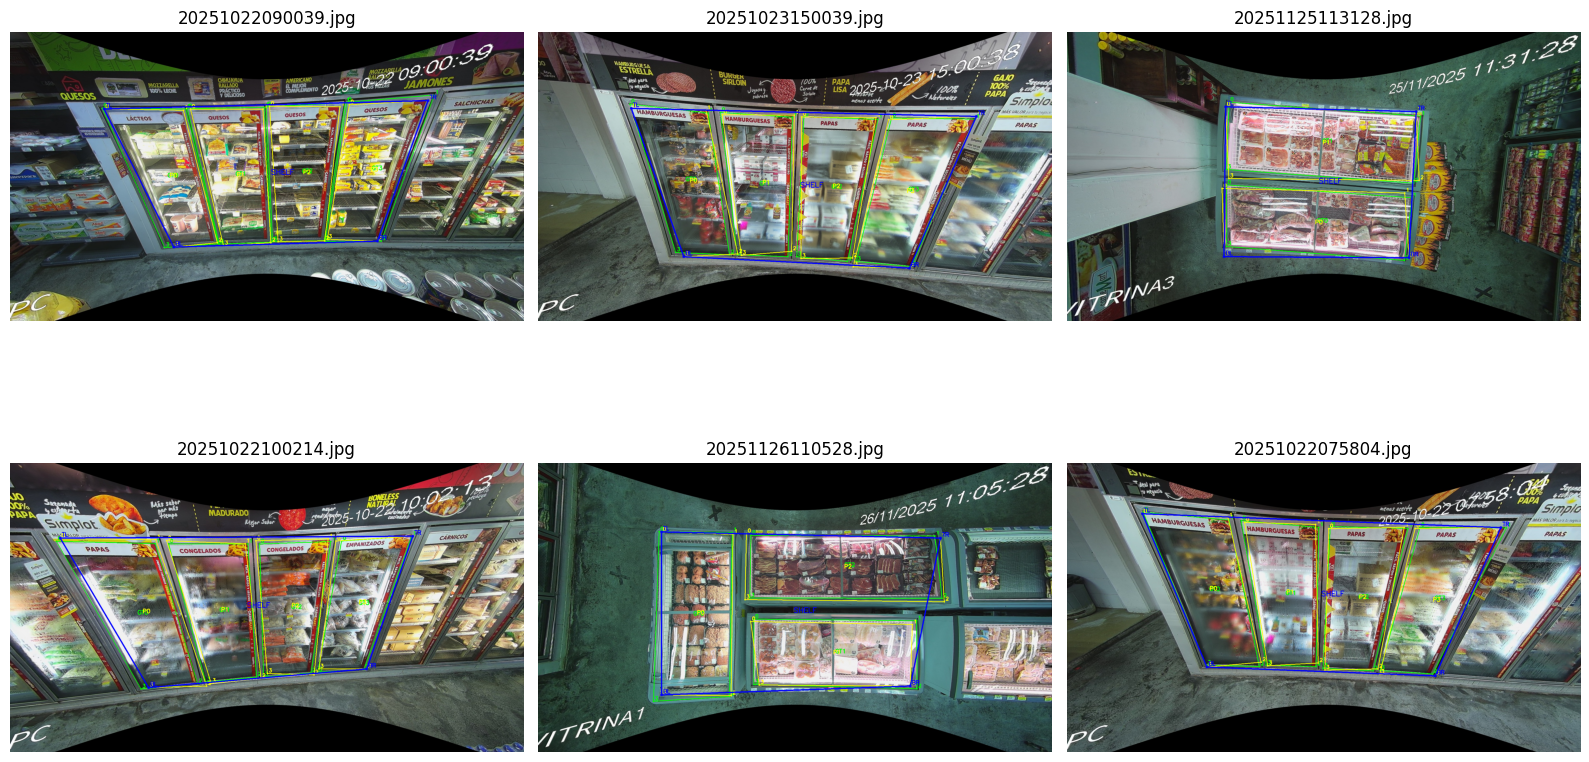

In [66]:
def show_preds_with_shelf(n=6, seed=42, conf=0.25, max_doors=4, shelf_method="lr"):
    imgs = sorted((YOLO_ROOT/"images/val").glob("*"))
    random.Random(seed).shuffle(imgs)
    imgs = imgs[:min(n, len(imgs))]

    plt.figure(figsize=(16, 10))
    for i, p in enumerate(imgs, 1):
        img = cv2.imread(str(p))
        H, W = img.shape[:2]

        gt = load_gt_from_label(YOLO_ROOT/"labels/val"/f"{p.stem}.txt", W, H)
        pr = predict_quads_ultralytics(model, p, conf=conf)

        shelf_quad, pr_sel = shelf_quad_from_doors_rectangle(pr, max_doors=max_doors)

        vis = draw_quads(img, gt, (0,255,0), "GT")
        vis = draw_quads(vis, pr_sel, (0,255,255), "P")     # solo las 4 puertas más a la izquierda
        vis = draw_quad(vis, shelf_quad, (255,0,0), "SHELF") # quad extremo

        vis = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)
        plt.subplot(2, math.ceil(len(imgs)/2), i)
        plt.imshow(vis); plt.axis("off"); plt.title(p.name)

    plt.tight_layout(); plt.show()

show_preds_with_shelf()

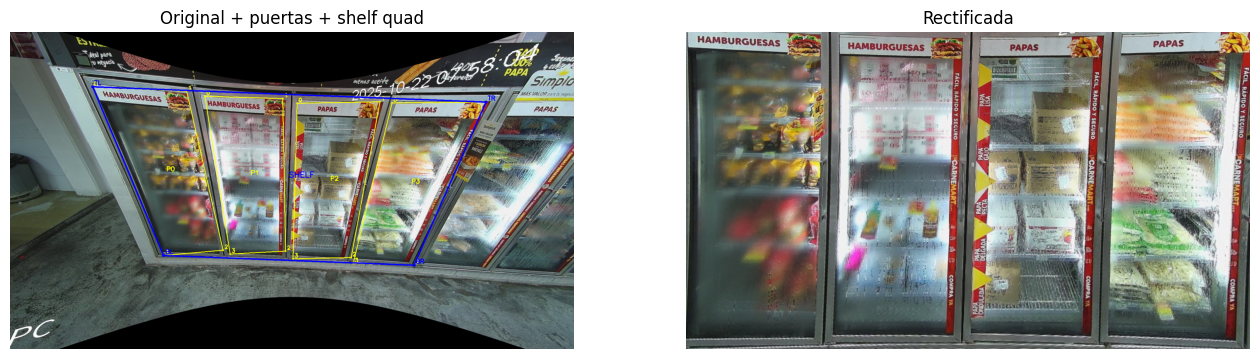

pts1 (TL,TR,BR,BL):
 [[     281.44      189.86]
 [     1620.7      241.49]
 [     1375.2      795.83]
 [     522.55      762.55]]
M:
 [[     1.3082    -0.55079     -263.61]
 [  -0.042201      1.0946     -195.93]
 [ 2.3071e-05 -0.00057841           1]]


In [70]:
def shelf_quad_from_prediction(model, image_path, conf=0.25, max_doors=4, method="lr"):
    img = cv2.imread(str(image_path))
    if img is None:
        raise FileNotFoundError(f"No pude leer la imagen: {image_path}")

    pr = predict_quads_ultralytics(model, image_path, conf=conf)
    shelf_quad, doors_used = shelf_quad_from_doors_rectangle(pr, max_doors=max_doors)
    return img, shelf_quad, doors_used

# Ejemplo:
IMAGE_PATH = Path(data_path + "unfisheye_data/20251022075804.jpg") # Cambiar imagen si se desea
original, pts1, doors_used = shelf_quad_from_prediction(model, IMAGE_PATH, conf=0.25, max_doors=4, method="lr")

if pts1 is None:
    print("No se pudo construir el quad extremo (sin puertas válidas).")
else:
    # Rectificar a un tamaño fijo (ej. 1920x1080), o usa None para mantener tamaño original.
    rectificada, M = rectify_by_homography(original, pts1, out_size=(1920, 1080))

    # Visualización rápida
    vis = draw_quads(original, doors_used, (0,255,255), "P")
    vis = draw_quad(vis, pts1, (255,0,0), "SHELF")

    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1); plt.title("Original + puertas + shelf quad"); plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)); plt.axis("off")
    plt.subplot(1,2,2); plt.title("Rectificada"); plt.imshow(cv2.cvtColor(rectificada, cv2.COLOR_BGR2RGB)); plt.axis("off")
    plt.show()

    print("pts1 (TL,TR,BR,BL):\n", pts1)
    print("M:\n", M)